<a href="https://colab.research.google.com/github/tacky726/uma/blob/main/%E7%AB%B6%E9%A6%AC%E4%BA%88%E6%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive"
import pandas as pd
!pip install pycaret
from pycaret.classification import setup, compare_models,  create_model
from pycaret.regression import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# netkeibaからスクレイピングしたデータを読み込む
df2019 = pd.read_csv("2019.csv", encoding="SHIFT_JIS")
df2020 = pd.read_csv("2020.csv", encoding="SHIFT_JIS")
df2021 = pd.read_csv("2021.csv", encoding="SHIFT_JIS")
df2022 = pd.read_csv("2022.csv", encoding="SHIFT_JIS")
df2023 = pd.read_csv("2023.csv", encoding="SHIFT_JIS")
df2024 = pd.read_csv("2024.csv", encoding="SHIFT_JIS")

df = pd.concat([df2019, df2020, df2021, df2022,df2023,df2024], ignore_index=True)

In [ ]:
# '日付'列をdatetime型に変換 (日本語形式のフォーマット指定)
df['日付'] = pd.to_datetime(df['日付'], format='%Y年%m月%d日')

# 日付順に並べ替え
df = df.sort_values(by='日付')

In [ ]:
# 機械学習しやすいようにデータを整える
cols = ['馬番','オッズ','着順','体重','体重変化','齢','斤量','上がり','人気','距離','場id']

# 時刻データをdatetime型に変換
df['走破時間'] = pd.to_datetime(df['走破時間'], format='%M:%S.%f')

# 時間を秒数に変換
df['走破時間'] = df['走破時間'].dt.hour * 3600 + df['走破時間'].dt.minute * 60 + df['走破時間'].dt.second

# 各カラムに対して pd.to_numeric を適用
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [ ]:
# 走破時間を秒に変換する関数
def convert_to_seconds(time_str):
    if isinstance(time_str, str):
        minutes, seconds = time_str.split(':')
        total_seconds = int(minutes) * 60 + float(seconds)
        return total_seconds
    return time_str  # 文字列でない場合はそのまま返す

# 走破時間列を秒に変換
df['走破時間_秒'] = df['走破時間'].apply(convert_to_seconds)

In [ ]:
# 秒速という新しいデータを作り出す
df['秒速'] = df['距離'] / df['走破時間_秒']

In [ ]:
# 秒速を調整して新しいデータを作り出す

# 全体平均秒速
全体平均秒速 = df['秒速'].mean()

# 距離ごとの平均秒速
距離ごとの平均秒速 = df.groupby('距離')['秒速'].mean()

# 距離ごとの平均秒速
芝ダートの平均秒速 = df.groupby('芝・ダート')['秒速'].mean()

馬場の平均秒速 = df.groupby('馬場')['秒速'].mean()

天気の平均秒速 = df.groupby('天気')['秒速'].mean()

場idの平均秒速 = df.groupby('場id')['秒速'].mean()
# 調整値を距離ごとに計算
df['調整後秒速'] = df['秒速'] * ( 全体平均秒速/df['距離'].map(距離ごとの平均秒速))*( 全体平均秒速/df['芝・ダート'].map(芝ダートの平均秒速))*( 全体平均秒速/df['馬場'].map(馬場の平均秒速))*( 全体平均秒速/df['天気'].map(天気の平均秒速))*( 全体平均秒速/df['場id'].map(場idの平均秒速))*100



In [ ]:
# いらないデータを捨てる
df.drop(['クラス','通過順','走破時間','開催','走破時間_秒','秒速','騎手','レース名','場名','場id','上がり','距離'],axis=1,inplace=True)

In [ ]:
# 直近のデータからその馬の実力を定義する

# 重みの設定（直前5行に対して加重）
def weighted_average(series):
    weights = np.arange(1, len(series) + 1)  # 重みを設定 (直近の行ほど大きな重み)
    return np.average(series, weights=weights)

# 同じ馬ごとの直前5行の加重平均を計算する関数
def calculate_weighted_average_for_group(group, column_name, window=5):
    results = []
    for i in range(len(group)):
        if i == 0:
            # 最初の行は直前の行が存在しないのでNaNに設定
            results.append(np.nan)
        else:
            # 現在の行を含まない直前の5行（またはそれ未満の行）を取得
            start_index = max(0, i - window)
            window_data = group.iloc[start_index:i][column_name]  # 自分自身を除外する
            if len(window_data) == 0:
                results.append(np.nan)  # データがない場合はNaNを返す
            else:
                avg = weighted_average(window_data)
                results.append(avg)
    return pd.Series(results, index=group.index)

# 馬ごとにグループ化し、加重平均を計算
df['調整後秒速馬_加重平均_直前5行'] = df.groupby('馬').apply(
    lambda group: calculate_weighted_average_for_group(group, '調整後秒速', window=5)
).reset_index(level=0, drop=True)

In [ ]:
import category_encoders as ce

list_cols = ['性','天気','回り','齢','芝・ダート','馬場']

# OneHotEncodeしたい列を指定。
ce_ohe = ce.OneHotEncoder(cols=list_cols,handle_unknown='impute')

# pd.DataFrameをそのまま突っ込む
df = ce_ohe.fit_transform(df)

In [ ]:
# 2023年と2024年の日付を抽出してテストデータとする
df_test = df[df['日付'].dt.year.isin([2023, 2024])]

In [ ]:
df = df.dropna(subset=['調整後秒速'])


In [ ]:
df_test = df_test.dropna(subset=['調整後秒速'])

In [ ]:
exp1 = setup(data = df, target = '調整後秒速', session_id=123,ignore_features = ['馬','着順','上がり','日付','race_id','馬番'] ,normalize = True)

,Description,Value
0,Session id,123
1,Target,調整後秒速
2,Target type,Regression
3,Original data shape,"(253473, 40)"
4,Transformed data shape,"(253473, 35)"
5,Transformed train set shape,"(177431, 35)"
6,Transformed test set shape,"(76042, 35)"
7,Ignore features,6
8,Numeric features,34
9,Rows with missing values,14.7%


In [ ]:
model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,22.6148,877.6219,29.6247,0.6402,0.0183,0.0139
1,22.6920,875.8906,29.5954,0.6395,0.0183,0.0139
2,22.7639,889.4528,29.8237,0.6273,0.0185,0.0140
3,22.7330,875.1774,29.5834,0.6350,0.0182,0.0140
4,22.7811,897.3094,29.9551,0.6378,0.0185,0.0140
5,22.6044,861.1636,29.3456,0.6405,0.0181,0.0139
6,22.6704,872.4779,29.5377,0.6347,0.0183,0.0139
7,22.5146,866.6508,29.4389,0.6439,0.0182,0.0138
8,22.5760,854.4171,29.2304,0.6572,0.0180,0.0139


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
final_model = finalize_model(model)

In [ ]:
result = predict_model(final_model, df_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,22.8697,907.1858,30.1195,0.6227,0.0187,0.0140


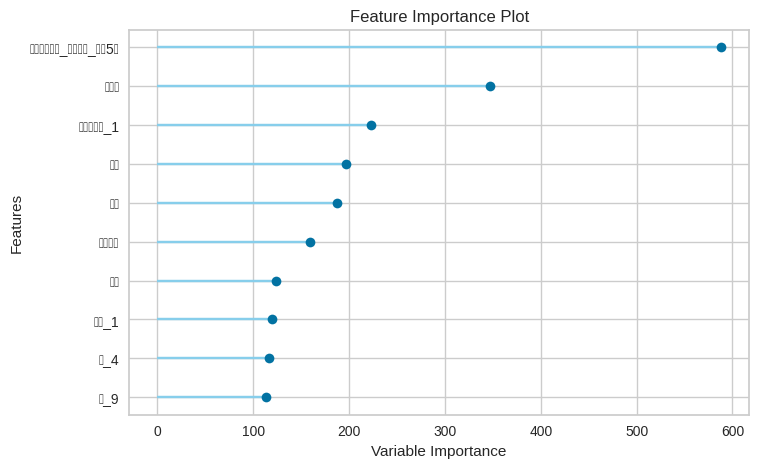

In [ ]:
plot_model(model, plot='feature') #特徴量プロット

In [ ]:
# 次に、df_testに新しく 'result' 列を作成し、その中に result を埋め込みます
df_test['result'] = result.iloc[:, -1]

In [ ]:
# 実際に一番だった馬に印付け
df_test['result_flag'] = df_test['着順'].apply(lambda x: 1 if x == 1.0 else 0)

# 各race_idごとのresult列の最大値のインデックスを取得
max_indices = df_test.groupby('race_id')['result'].idxmax()
# 新しい列 'is_max_result' を作成し、最大値の行に1、それ以外に0を設定
df_test['is_max_result'] = 0
df_test.loc[max_indices, 'is_max_result'] = 1

# 各レース名と日付ごとにresult列の最大値のインデックスを取得
idx = df_test.groupby('race_id')['調整後秒速'].idxmax()

# 新しい列 'is_max_result' を作成し、最大値の行に1、それ以外に0を設定
df_test['is_max_調整後秒速'] = 0
df_test.loc[idx, 'is_max_調整後秒速'] = 1

In [ ]:
#単純に全て賭けた場合
num_rows = len(idx)
total_result = (df_test['オッズ'] * df_test['is_max_result']*df_test['result_flag']).sum() / num_rows
print(total_result)

0.7851956358164034


このように予想した物を単勝で全て賭けた場合、平均の0.8にわずかに及ばない結果になります。
そのため、次は賭け方を変えて見ることにしました。このように予測において2番目との馬とどれだけ優位があるかを調べてそれを数値化しました。

In [ ]:
# race_idごとにグループ化して、resultを降順にソート
df_sorted = df_test.sort_values(by=['race_id', 'result'], ascending=[True, False])

# race_idごとに、1番目と2番目のresultを抽出
df_top2 = df_sorted.groupby('race_id').head(2)

# 1番目と2番目の値を引いて、それを1番目の値で割る
def calculate_ratio(group):
    if len(group) < 2:
        return None  # 2つ以上の結果がない場合は計算しない
    first = group.iloc[0]['result']
    second = group.iloc[1]['result']
    return (first - second) / first

# 各race_idごとに計算
result_ratios2 = df_top2.groupby('race_id').apply(calculate_ratio).dropna()

# 元のデータフレームにこの結果を追加
df_test['calculated_ratio'] = df_test['race_id'].map(result_ratios2)


In [ ]:
# race_idごとにグループ化して、調整後秒速を降順にソート
df_sorted = df_test.sort_values(by=['race_id', '調整後秒速'], ascending=[True, False])

# race_idごとに、1番目と2番目の調整後秒速を抽出
df_top2 = df_sorted.groupby('race_id').head(2)

# 1番目と2番目の値を引いて、それを1番目の値で割る
def calculate_ratio(group):
    if len(group) < 2:
        return None  # 2つ以上の結果がない場合は計算しない
    first = group.iloc[0]['調整後秒速']
    second = group.iloc[1]['調整後秒速']
    return (first - second) / first

# 各race_idごとに計算
result_ratios1 = df_top2.groupby('race_id').apply(calculate_ratio).dropna()

print(result_ratios1)

race_id
202301010101    0.000000
202301010102    0.016949
202301010103    0.000000
202301010104    0.000000
202301010105    0.009174
                  ...   
202410030808    0.000000
202410030809    0.000000
202410030810    0.000000
202410030811    0.000000
202410030812    0.000000
Length: 5316, dtype: float64


オッヅが低い馬程この機械学習に反映できていない要素（調教や血統等）が反映されていると考え、オッヅで割ります。そしてその値で上位1%の馬のみに印をつけます。

In [ ]:
# calculated_ratio列をオッづを割る
df_test['weighted_ratio'] =  df_test['calculated_ratio'] *df_test['is_max_result']/df_test['オッズ']

# 上位10%の閾値を計算
threshold = np.percentile(df_test['weighted_ratio'].dropna(), 99)

# 上位10%に1、それ以外に0を割り当てる
df_test['top_1_percent'] = np.where(df_test['weighted_ratio'] >= threshold, 1, 0)


In [ ]:
# top_10_percent列で1の数をカウント
count_top_10_percent = df_test['top_1_percent'].sum()
total_result = (df_test['オッズ'] * df_test['is_max_result']*df_test['result_flag']*df_test['top_1_percent']).sum() / count_top_10_percent
print(total_result)

0.8536451169188446


先程よりも数値が上がって、人間が平均的に予想した値である0.8を超えられるようになりました。月ごとのリターンを見てみると次のようになりました。

In [ ]:
# 月ごとにグループ化してリターンを計算
monthly_results_before = df_test.groupby(df_test['日付'].dt.to_period('M')).apply(
    lambda x: (x['オッズ'] * x['is_max_result'] * x['result_flag'] ).sum() / x['is_max_result'].sum()
)

# 結果を表示
print(monthly_results_before)


日付
2023-01    0.911000
2023-02    0.747727
2023-03    0.835088
2023-04    0.791667
2023-05    0.857292
2023-06    0.765909
2023-07    0.778274
2023-08    0.787500
2023-09    0.748485
2023-10    0.706410
2023-11    0.695455
2023-12    0.684722
2024-01    0.895139
2024-02    0.821875
2024-03    0.952083
2024-04    0.710764
2024-05    0.725000
2024-06    0.783631
2024-07    0.662719
2024-08    0.818750
Freq: M, dtype: float64


In [ ]:
# 月ごとにグループ化してリターンを計算
monthly_results_after = df_test.groupby(df_test['日付'].dt.to_period('M')).apply(
    lambda x: (x['オッズ'] * x['is_max_result'] * x['result_flag'] * x['top_1_percent']).sum() / x['top_1_percent'].sum()
)

# 結果を表示
print(monthly_results_after)

日付
2023-01    1.186842
2023-02    0.757143
2023-03    0.795652
2023-04    0.534615
2023-05    1.012121
2023-06    0.806452
2023-07    0.772222
2023-08    0.997368
2023-09    1.139024
2023-10    0.676316
2023-11    0.882353
2023-12    1.160000
2024-01    0.789474
2024-02    1.129545
2024-03    0.639062
2024-04    0.856000
2024-05    1.012000
2024-06    0.695556
2024-07    0.718182
2024-08    0.580000
Freq: M, dtype: float64
